# Assignment I: Faster R-CNN vs YOLOv8
## Robert Chen, B20-AI
### r.chen@innopolis.university

## 0. Imports

For Colab:

In [ ]:
%matplotlib inline
!pip install roboflow
!pip install ultralytics

Installing detectron2 (important)

In [ ]:
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 14867, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 14867 (delta 17), reused 26 (delta 10), pack-reused 14826
Receiving objects: 100% (14867/14867), 6.06 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (10759/10759), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-

Imports

In [ ]:
from roboflow import Roboflow
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from datetime import datetime

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import glob

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# TRAINING
from detectron2.engine import DefaultTrainer
import cv2
from google.colab.patches import cv2_imshow

## 1. Faster R-CNN

First, we need to download the dataset in COCO format:

In [ ]:
rf = Roboflow(api_key="MajynWO1gWkBtWw9SHyL")
project = rf.workspace("b20ai").project("faster-rcnn-yolov8")
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Faster-RCNN/YOLOv8-1 in coco:: 100%|██████████| 108/108 [00:00<00:00, 422.54it/s]


Now, we need to register the model before training it:


In [ ]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME, 
    metadata={}, 
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH, 
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME, 
    metadata={}, 
    json_file=TEST_DATA_SET_ANN_FILE_PATH, 
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME, 
    metadata={}, 
    json_file=VALID_DATA_SET_ANN_FILE_PATH, 
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

Setting up the configuration:

In [ ]:
# HYPERPARAMETERS
ARCHITECTURE = "faster_rcnn_X_101_32x8d_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 800
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 3

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME, 
    ARCHITECTURE, 
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

Getting the model from model zoo:

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 30
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

Finally, training:

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/06 16:45:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[03/06 16:45:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...


model_final_68b088.pkl: 421MB [00:04, 89.0MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/06 16:45:14 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)


[03/06 16:45:55 d2.utils.events]:  eta: 0:17:31  iter: 19  total_loss: 2.444  loss_cls: 1.422  loss_box_reg: 1.001  loss_rpn_cls: 0.009235  loss_rpn_loc: 0.007486  time: 1.3587  last_time: 1.3453  data_time: 0.1043  last_data_time: 0.0099   lr: 2.4726e-05  max_mem: 4228M
[03/06 16:46:24 d2.utils.events]:  eta: 0:18:30  iter: 39  total_loss: 2.063  loss_cls: 1.077  loss_box_reg: 0.9888  loss_rpn_cls: 0.00793  loss_rpn_loc: 0.01172  time: 1.4100  last_time: 1.5932  data_time: 0.0131  last_data_time: 0.0276   lr: 4.9701e-05  max_mem: 4228M
[03/06 16:46:54 d2.utils.events]:  eta: 0:18:06  iter: 59  total_loss: 1.704  loss_cls: 0.7212  loss_box_reg: 0.9768  loss_rpn_cls: 0.004838  loss_rpn_loc: 0.008266  time: 1.4317  last_time: 1.5183  data_time: 0.0077  last_data_time: 0.0192   lr: 7.4676e-05  max_mem: 4228M
[03/06 16:47:22 d2.utils.events]:  eta: 0:17:40  iter: 79  total_loss: 1.542  loss_cls: 0.5407  loss_box_reg: 0.9885  loss_rpn_cls: 0.003295  loss_rpn_loc: 0.009871  time: 1.4328  las

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[03/06 16:50:46 d2.utils.events]:  eta: 0:14:16  iter: 219  total_loss: 0.5127  loss_cls: 0.1218  loss_box_reg: 0.3863  loss_rpn_cls: 2.055e-05  loss_rpn_loc: 0.009497  time: 1.4476  last_time: 1.6319  data_time: 0.0126  last_data_time: 0.0111   lr: 0.00027448  max_mem: 4229M
[03/06 16:51:15 d2.utils.events]:  eta: 0:13:39  iter: 239  total_loss: 0.3785  loss_cls: 0.08291  loss_box_reg: 0.2664  loss_rpn_cls: 3.152e-05  loss_rpn_loc: 0.006273  time: 1.4452  last_time: 1.6230  data_time: 0.0117  last_data_time: 0.0055   lr: 0.00029945  max_mem: 4229M
[03/06 16:51:45 d2.utils.events]:  eta: 0:13:17  iter: 259  total_loss: 0.3249  loss_cls: 0.0768  loss_box_reg: 0.2456  loss_rpn_cls: 9.754e-06  loss_rpn_loc: 0.004467  time: 1.4496  last_time: 1.5385  data_time: 0.0128  last_data_time: 0.0135   lr: 0.00032443  max_mem: 4229M
[03/06 16:52:14 d2.utils.events]:  eta: 0:12:50  iter: 279  total_loss: 0.3143  loss_cls: 0.06845  loss_box_reg: 0.2247  loss_rpn_cls: 3.46e-05  loss_rpn_loc: 0.0047  t

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[03/06 16:55:38 d2.utils.events]:  eta: 0:09:27  iter: 419  total_loss: 0.2359  loss_cls: 0.05114  loss_box_reg: 0.1903  loss_rpn_cls: 1.613e-05  loss_rpn_loc: 0.003148  time: 1.4521  last_time: 1.4051  data_time: 0.0093  last_data_time: 0.0061   lr: 0.00052423  max_mem: 4229M
[03/06 16:56:07 d2.utils.events]:  eta: 0:08:59  iter: 439  total_loss: 0.2235  loss_cls: 0.04227  loss_box_reg: 0.1734  loss_rpn_cls: 5.767e-06  loss_rpn_loc: 0.003218  time: 1.4522  last_time: 1.6252  data_time: 0.0105  last_data_time: 0.0067   lr: 0.0005492  max_mem: 4229M
[03/06 16:56:36 d2.utils.events]:  eta: 0:08:30  iter: 459  total_loss: 0.207  loss_cls: 0.03957  loss_box_reg: 0.1562  loss_rpn_cls: 1.522e-05  loss_rpn_loc: 0.002744  time: 1.4529  last_time: 1.6293  data_time: 0.0101  last_data_time: 0.0059   lr: 0.00057418  max_mem: 4229M
[03/06 16:57:05 d2.utils.events]:  eta: 0:07:55  iter: 479  total_loss: 0.2028  loss_cls: 0.03327  loss_box_reg: 0.1639  loss_rpn_cls: 4.644e-06  loss_rpn_loc: 0.002726

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[03/06 17:00:30 d2.utils.events]:  eta: 0:04:33  iter: 619  total_loss: 0.1783  loss_cls: 0.02853  loss_box_reg: 0.1389  loss_rpn_cls: 3.844e-06  loss_rpn_loc: 0.002626  time: 1.4550  last_time: 1.5272  data_time: 0.0112  last_data_time: 0.0060   lr: 0.00077398  max_mem: 4229M
[03/06 17:01:00 d2.utils.events]:  eta: 0:04:02  iter: 639  total_loss: 0.1715  loss_cls: 0.03321  loss_box_reg: 0.1413  loss_rpn_cls: 5.656e-06  loss_rpn_loc: 0.001595  time: 1.4552  last_time: 1.0810  data_time: 0.0117  last_data_time: 0.0063   lr: 0.00079895  max_mem: 4229M
[03/06 17:01:29 d2.utils.events]:  eta: 0:03:32  iter: 659  total_loss: 0.1867  loss_cls: 0.04012  loss_box_reg: 0.1443  loss_rpn_cls: 1.748e-05  loss_rpn_loc: 0.002582  time: 1.4556  last_time: 1.5519  data_time: 0.0126  last_data_time: 0.0217   lr: 0.00082393  max_mem: 4229M
[03/06 17:01:58 d2.utils.events]:  eta: 0:03:02  iter: 679  total_loss: 0.1804  loss_cls: 0.03435  loss_box_reg: 0.1466  loss_rpn_cls: 9.607e-06  loss_rpn_loc: 0.0019

This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Evaluation:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(TEST_DATA_SET_NAME, cfg, False, output_dir=OUTPUT_DIR_PATH)
val_loader = build_detection_test_loader(cfg, TEST_DATA_SET_NAME)
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/06 17:05:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Faster-RCNN/YOLOv8/faster_rcnn_X_101_32x8d_FPN_3x/2023-03-06-16-44-51/model_final.pth ...
[03/06 17:05:15 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/06 17:05:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/06 17:05:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 17:05:15 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/Faster-RCNN/YOLOv8-1/test/_annotations.coco.json
[03/06 17:05:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/06 17:05:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.da

OrderedDict([('bbox',
              {'AP': 75.36674917491749,
               'AP50': 92.24422442244224,
               'AP75': 92.24422442244224,
               'APs': nan,
               'APm': nan,
               'APl': 75.36674917491749,
               'AP-asuka-power': nan,
               'AP-asuka': 71.27475247524754,
               'AP-power': 79.45874587458745})])

Visualising the test set:

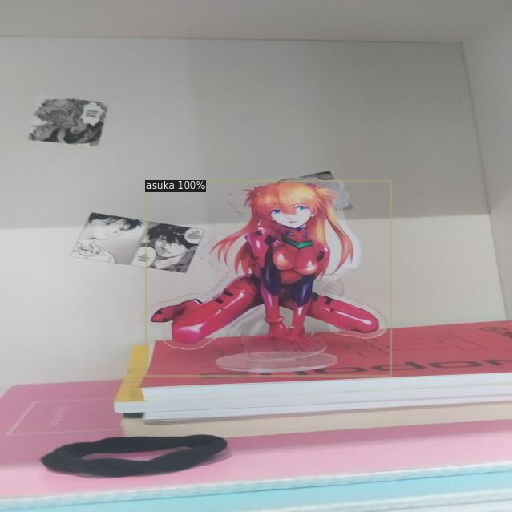

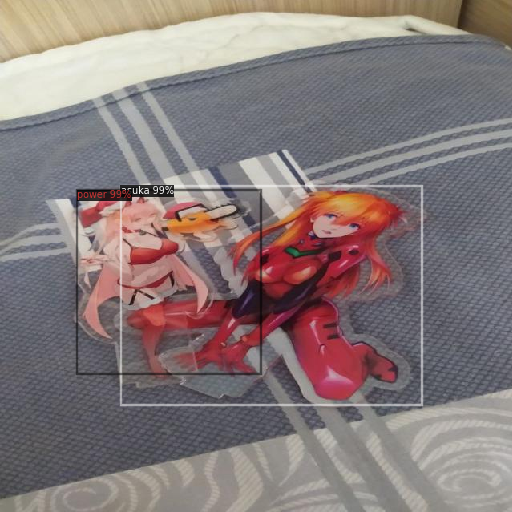

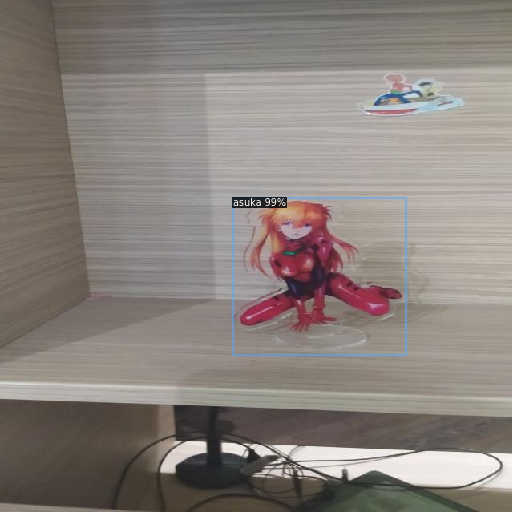

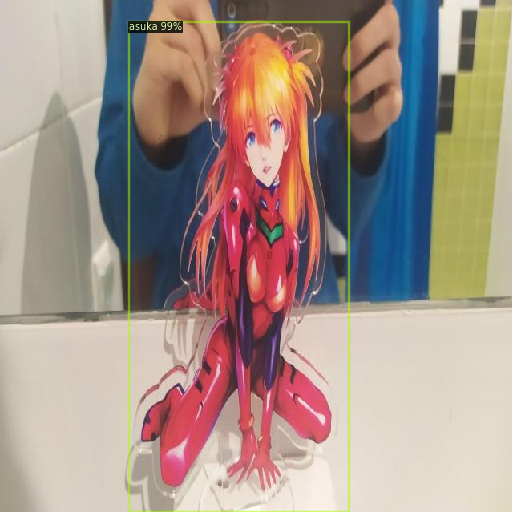

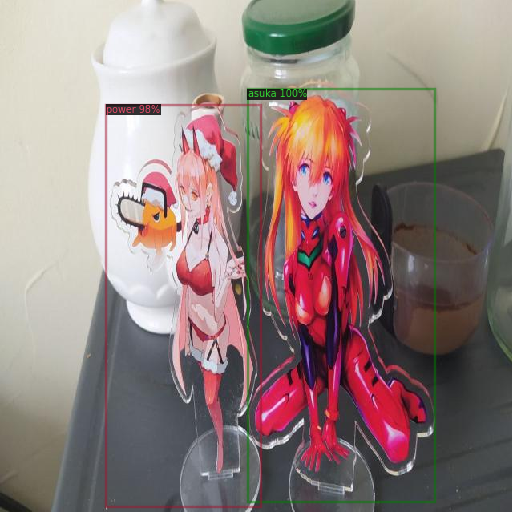

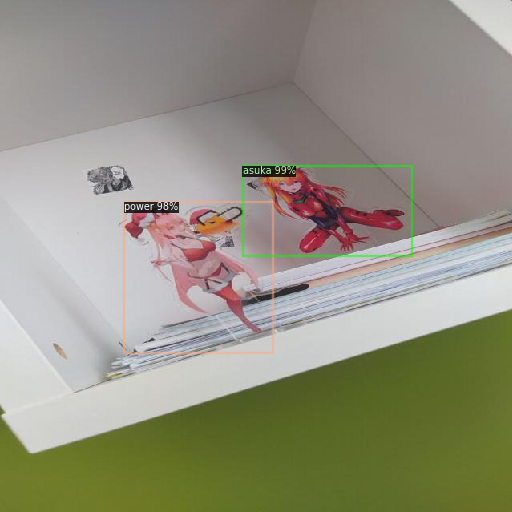

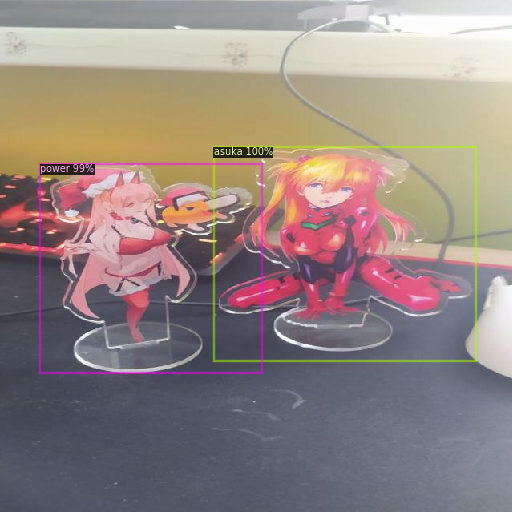

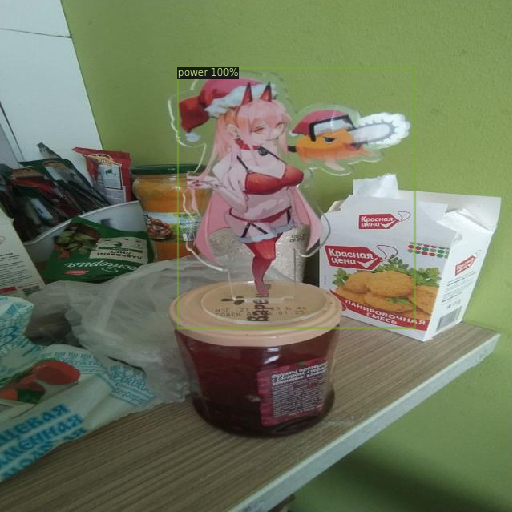

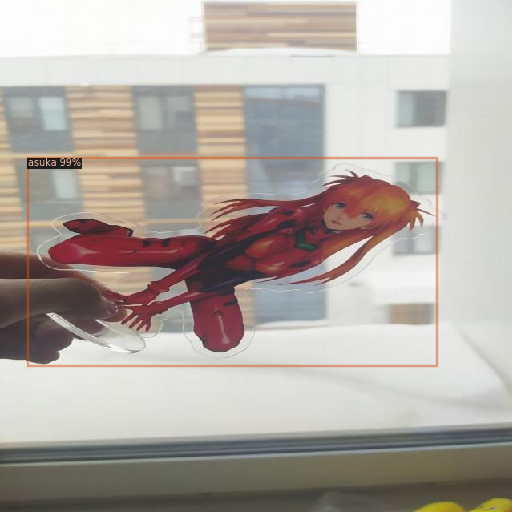

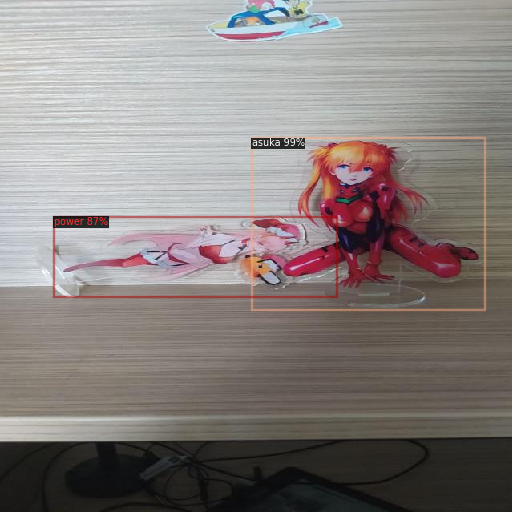

In [ ]:
test_metadata = MetadataCatalog.get(TEST_DATA_SET_NAME)

for imageName in glob.glob(f'/{dataset.location}/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

## 2. YOLOv8

First, let us download the dataset:

In [ ]:
dataset = project.version(1).download("yolov8")

Dependency ultralytics<=8.0.20 is required but found version=8.0.50, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to Faster-RCNN/YOLOv8-1 in yolov8:: 100%|██████████| 212/212 [00:00<00:00, 2253.82it/s]


In [ ]:
model = YOLO('yolov8n.pt')

model.train(data=f'{dataset.location}/data.yaml', epochs=100, batch=20, imgsz=640)

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.50 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Faster-RCNN/YOLOv8-1/data.yaml, epochs=100, patience=50, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, in

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

  0%|          | 0.00/476k [00:00<?, ?B/s]

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias
train: Scanning /content/Faster-RCNN/YOLOv8-1/train/labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 2071.50it/s]
train: New cache created: /content/Faster-RCNN/YOLOv8-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /content/Faster-RCNN/YOLOv8-1/valid/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 1910.89it/s]
val: New cache created: /content/Faster-RCNN/YOLOv8-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_m

Now, for the results:

In [ ]:
results = model(conf=0.4, save=True, source=f'{dataset.location}/test/images')


image 1/10 /content/Faster-RCNN/YOLOv8-1/test/images/photo_1_2023-03-06_11-42-35_jpg.rf.28d590a8cc268cb0649f7a5b33b53a70.jpg: 640x640 1 asuka, 14.2ms
image 2/10 /content/Faster-RCNN/YOLOv8-1/test/images/photo_2_2023-03-06_11-39-40_jpg.rf.12e2c28adc1cc7399732716a2746604c.jpg: 640x640 1 asuka, 14.7ms
image 3/10 /content/Faster-RCNN/YOLOv8-1/test/images/photo_2_2023-03-06_11-42-39_jpg.rf.1d5380d54ae5349b51793abe56d244be.jpg: 640x640 1 asuka, 1 power, 15.1ms
image 4/10 /content/Faster-RCNN/YOLOv8-1/test/images/photo_5_2023-03-06_11-42-59_jpg.rf.c7948628b802ed2f9579f87ce5bdfb60.jpg: 640x640 1 asuka, 1 power, 14.2ms
image 5/10 /content/Faster-RCNN/YOLOv8-1/test/images/photo_7_2023-03-06_11-42-31_jpg.rf.629da3e8c6c6cf0386a9f6a11f7f039b.jpg: 640x640 1 power, 14.2ms
image 6/10 /content/Faster-RCNN/YOLOv8-1/test/images/photo_7_2023-03-06_11-42-39_jpg.rf.a5cc958de860f9070ef9c537951a1d14.jpg: 640x640 1 asuka, 1 power, 14.3ms
image 7/10 /content/Faster-RCNN/YOLOv8-1/test/images/photo_8_2023-03-06_

Visualisation:

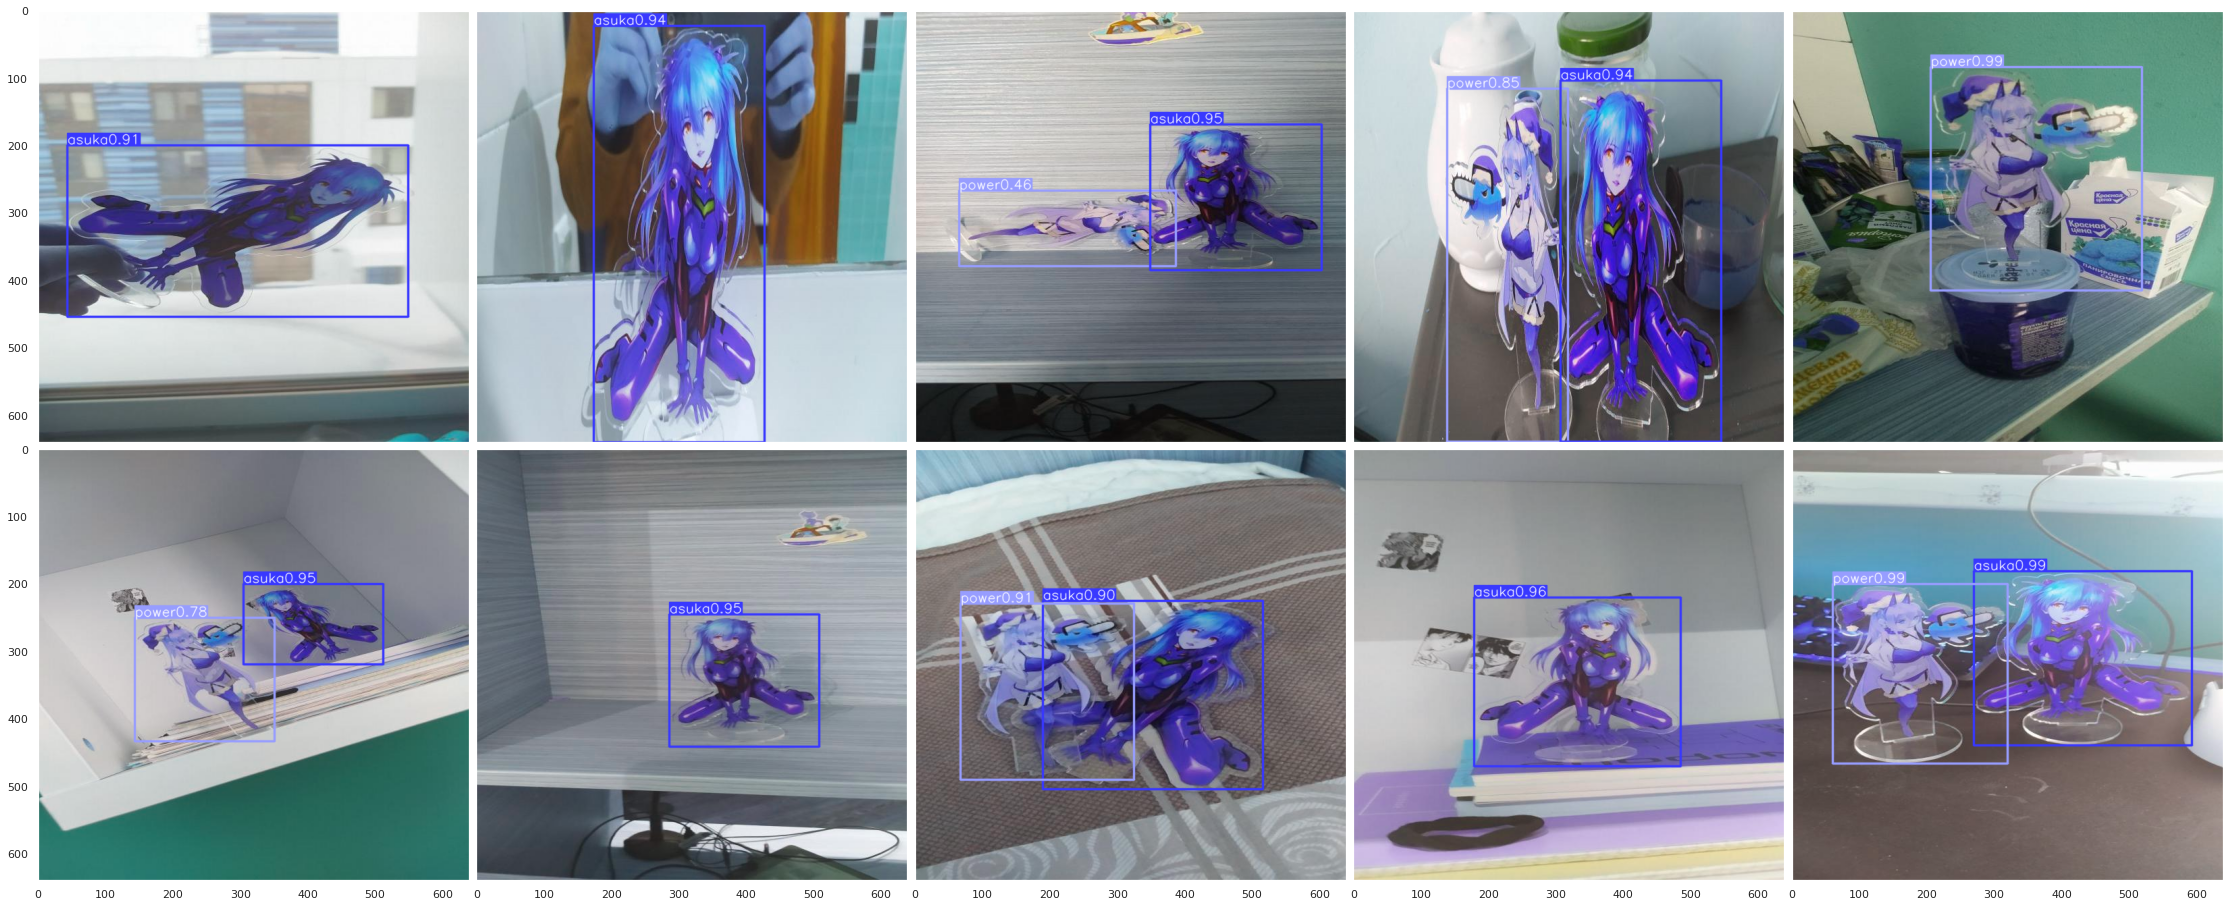

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(60, 16))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


for ax, result in zip(grid, results):
  plotted = result.plot()
  ax.imshow(plotted)
  ax.grid(False)

plt.grid(False)
plt.show()

## 3. Comparison


For Faster R-CNN metrics are:
- mAP50-95: 75.367%
- Training time: 19m24s
- Total inference time (test set, 10 images): 1s939ms

For YOLOv8 metrics are:
- mAP50-95: 75.6%
- Training time: 9m36s
- Total inference time (test set, 10 images): 1s500ms

As we can see, YOLOv8 is superior in both precision and efficiency. YOLOv8's training time is twice as low as Faster R-CNN, inference time per image is 33% faster, which makes it more useful for the real-time tasks, and precision is on par and even superior to Faster R-CNN. Furthermore, it took 798 iterations for R-CNN to achieve such result, and only 100 epochs for YOLOv8. Also, YOLOv8 is much easier to use in comparison with Faster R-CNN, although detectron2 allows much more flexibility than ultralytics (for example, detectron2 offers a model zoo to select a pretrained model, with some of them being more advanced than Faster R-CNN like Mask R-CNN)
 